In [1]:
import pandas as pd
import time
import numpy as np
import struct
import matplotlib.pyplot as plt
from cr_data_inspection_functions import *
from lwa_antpos import mapping
from scipy.optimize import curve_fit
import scipy.stats as st
import math


Read antpos from xlsx file in repo


In [170]:
#summary_filename='/data0/cosmic-ray-data/2023May3-dataproducts/summary.txt'
summary_filename0='/data0/cosmic-ray-data/2023June20-data-products/summary.txt'
summary_filename1='/data1/cosmic-ray-data/2023June20-data-products/summary.txt'

summary_filenames=[summary_filename0,summary_filename1]

colnames=['fname',
          'total_event_count',
          'complete_events_count',
          'incomplete_events_count',
          'scrambled_complete_events',
          'pass_rms_change_cut',
          'pass_veto_cut',
          'pass_max_distant_vs_core_cut',
          'pass_top5_distant_vs_core_cut',
          'pass_distant_vs_core_cut2',
          'total_selected_v1',
          'total_selected_v2']

all_lines=[]
for summary_filename in summary_filenames:
    with open(summary_filename) as file:
        lines = [line.rstrip().split() for line in file if line[:2]=='ov']
    all_lines+=lines
    
summary = pd.DataFrame(columns=colnames,index=range(len(all_lines)))



In [171]:
print(len(lines))
print(len(all_lines))

576
1155


In [172]:
for j,line in enumerate(all_lines):
    for i in range(len(line)):
        if i: #skip the first one
            line[i]=int(line[i])
    summary.loc[j]=line
            
    

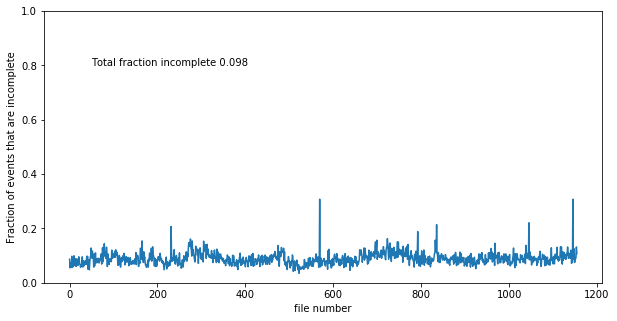

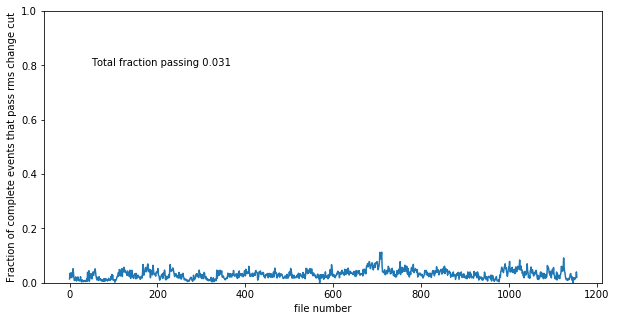

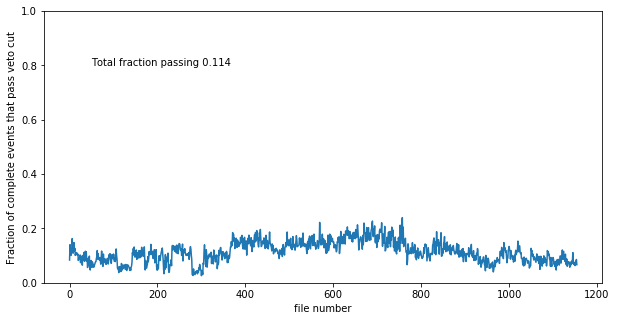

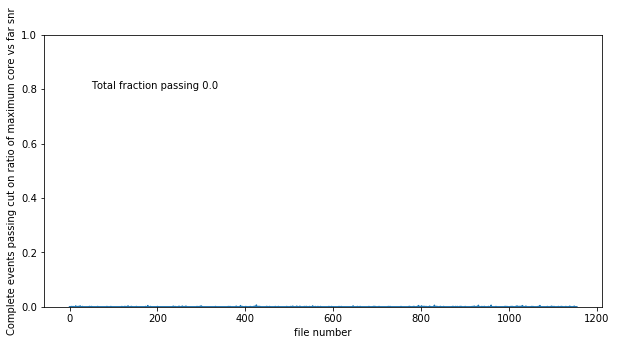

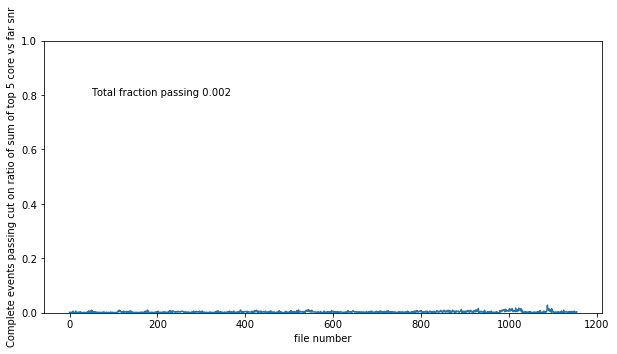

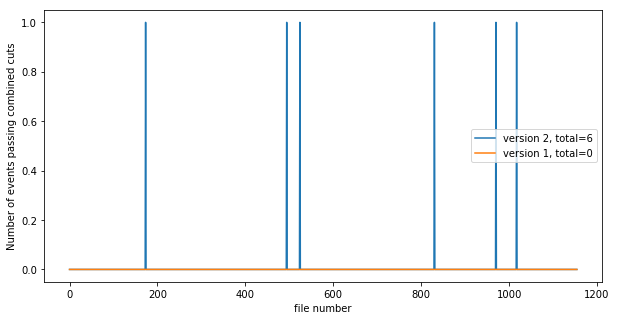

In [173]:
plt.figure(figsize=(10,5))
plt.xlabel('file number')
plt.ylabel('Fraction of events that are incomplete')
plt.plot(summary['incomplete_events_count']/summary['total_event_count'])
plt.ylim(0,1)
total=summary['incomplete_events_count'].sum()/summary['complete_events_count'].sum()
plt.text(50,0.8,'Total fraction incomplete '+str(round(total,3)))

plt.figure(figsize=(10,5))
plt.xlabel('file number')
plt.ylabel('Fraction of complete events that pass rms change cut')
plt.plot(summary['pass_rms_change_cut']/summary['complete_events_count'])
plt.ylim(0,1)
total=summary['pass_rms_change_cut'].sum()/summary['complete_events_count'].sum()
plt.text(50,0.8,'Total fraction passing '+str(round(total,3)))

plt.figure(figsize=(10,5))
plt.xlabel('file number')
plt.ylabel('Fraction of complete events that pass veto cut')
plt.plot(summary['pass_veto_cut']/summary['complete_events_count'])
total=summary['pass_veto_cut'].sum()/summary['complete_events_count'].sum()
plt.text(50,0.8,'Total fraction passing '+str(round(total,3)))
plt.ylim(0,1)

plt.figure(figsize=(10,5))
plt.xlabel('file number')
plt.ylabel('Complete events passing cut on ratio of maximum core vs far snr')
plt.plot(summary['pass_max_distant_vs_core_cut']/summary['complete_events_count'])
total=summary['pass_max_distant_vs_core_cut'].sum()/summary['complete_events_count'].sum()
plt.text(50,0.8,'Total fraction passing '+str(round(total,3)))

plt.ylim(0,1)

plt.figure(figsize=(10,5))
plt.xlabel('file number')
plt.ylabel('Complete events passing cut on ratio of sum of top 5 core vs far snr')
plt.plot(summary['pass_top5_distant_vs_core_cut']/summary['complete_events_count'])
total=summary['pass_top5_distant_vs_core_cut'].sum()/summary['complete_events_count'].sum()
plt.text(50,0.8,'Total fraction passing '+str(round(total,3)))
plt.ylim(0,1)

plt.figure(figsize=(10,5))
plt.xlabel('file number')
plt.ylabel('Number of events passing combined cuts')
plt.plot(summary['total_selected_v2'],label='version 2, total='+str(summary['total_selected_v2'].sum()))
plt.plot(summary['total_selected_v1'],label='version 1, total='+str(summary['total_selected_v1'].sum()))
plt.legend()


In [174]:
print(summary.columns)

Index(['fname', 'total_event_count', 'complete_events_count',
       'incomplete_events_count', 'scrambled_complete_events',
       'pass_rms_change_cut', 'pass_veto_cut', 'pass_max_distant_vs_core_cut',
       'pass_top5_distant_vs_core_cut', 'pass_distant_vs_core_cut2',
       'total_selected_v1', 'total_selected_v2'],
      dtype='object')


In [176]:
for name in summary.columns:
    if name!='fname':
        print(name,summary[name].sum())
print(summary['total_selected_v1'].sum()/summary['complete_events_count'].sum())
print(summary['total_selected_v2'].sum()/summary['complete_events_count'].sum())

total_event_count 1160259
complete_events_count 1056920
incomplete_events_count 103339
scrambled_complete_events 0
pass_rms_change_cut 32999
pass_veto_cut 120756
pass_max_distant_vs_core_cut 230
pass_top5_distant_vs_core_cut 2623
pass_distant_vs_core_cut2 2707
total_selected_v1 0
total_selected_v2 6
0.0
5.676872421753775e-06


## Examine events that passed 
No events passed the v1 cut in the night of June 20, so I'm plotting the v2 cuts.  I run the code twice (different cells) to look at events in data0 or data1. This could be streamlined in the future.

In [180]:
files_with_interesting_events=[]
for i in range(len(summary)):
    if (summary['total_selected_v2'][i]):
        print(summary['fname'][i],summary['total_selected_v1'][i],summary['total_selected_v2'][i])
        files_with_interesting_events.append(summary['fname'][i])
        

overnight1687334088.3248677.dat 0 1
overnight1687336322.695718.dat 0 1
overnight1687336523.8225608.dat 0 1
overnight1687338405.03751.dat 0 1
overnight1687339394.3801334.dat 0 1
overnight1687339688.548277.dat 0 1


In [186]:
datadir='/data0/cosmic-ray-data/2023June20/'
dataproductsdir='/data0/cosmic-ray-data/2023June20-data-products/'

for datafname in files_with_interesting_events[:3]:
    saved_events_indices=np.load(dataproductsdir+datafname[:-3]+'indices_cuts2.npy')
    for i in saved_events_indices:
        event_records=parsefile(datadir+datafname,start_ind=i,end_ind=704 )
        merged=mergepolarizations(event_records,arraymapdictionaries)
        print(sum(['rmsB' in m.keys() for m in merged]))
        
        plot_event_peak_to_rms(event_records,arraymapdictionaries,minimum_ok_rms=25,maximum_ok_rms=45,minimum_ok_kurtosis=-1,maximum_ok_kurtosis=1,annotate=False)
        plot_event_toas(event_records,arraymapdictionaries,minimum_ok_rms=25,maximum_ok_rms=45,minimum_ok_kurtosis=-1,maximum_ok_kurtosis=1,annotate=False)

        coreA,coreB,farA,farB=rank_by_snr(event_records,arraymapdictionaries)
        for rankedlist in coreA,coreB,farA,farB:
            if len(rankedlist)>1:
                plot_timeseries(event,[A[1] for A in rankedlist[:1]],zoom='peak')
            else:
                plot_timeseries(event,[A[1] for A in rankedlist],zoom='peak')

FileNotFoundError: [Errno 2] No such file or directory: '/data0/cosmic-ray-data/2023June20-data-products/overnight1687334088.3248677.indices_cuts2.npy'

In [ ]:

datadir='/data1/cosmic-ray-data/2023June20/'
dataproductsdir='/data1/cosmic-ray-data/2023June20-dataproducts/'

for datafname in files_with_interesting_events:
    saved_events_indices=np.load(dataproductsdir+datafname[:-3]+'indices_cuts1.npy')
    for i in saved_events_indices:
        event_records=parsefile(datadir+datafname,start_ind=i,end_ind=704 )
        merged=mergepolarizations(event_records,arraymapdictionaries)
        print(sum(['rmsB' in m.keys() for m in merged]))
        
        plot_event_peak_to_rms(event_records,arraymapdictionaries,minimum_ok_rms=25,maximum_ok_rms=45,minimum_ok_kurtosis=-1,maximum_ok_kurtosis=1,annotate=False)
        plot_event_toas(event_records,arraymapdictionaries,minimum_ok_rms=25,maximum_ok_rms=45,minimum_ok_kurtosis=-1,maximum_ok_kurtosis=1,annotate=False)

        coreA,coreB,farA,farB=rank_by_snr(event_records,arraymapdictionaries)
        for rankedlist in coreA,coreB,farA,farB:
            if len(rankedlist)>1:
                plot_timeseries(event,[A[1] for A in rankedlist[:1]],zoom='peak')
            else:
                plot_timeseries(event,[A[1] for A in rankedlist],zoom='peak')

## Functions and further inspection

peak ratio A 1.1762385061784777
peak ratio B 1.4135957022898622
top 5 ratio A 1.1736495164072298
top 5 ratio B 1.5261968132364527


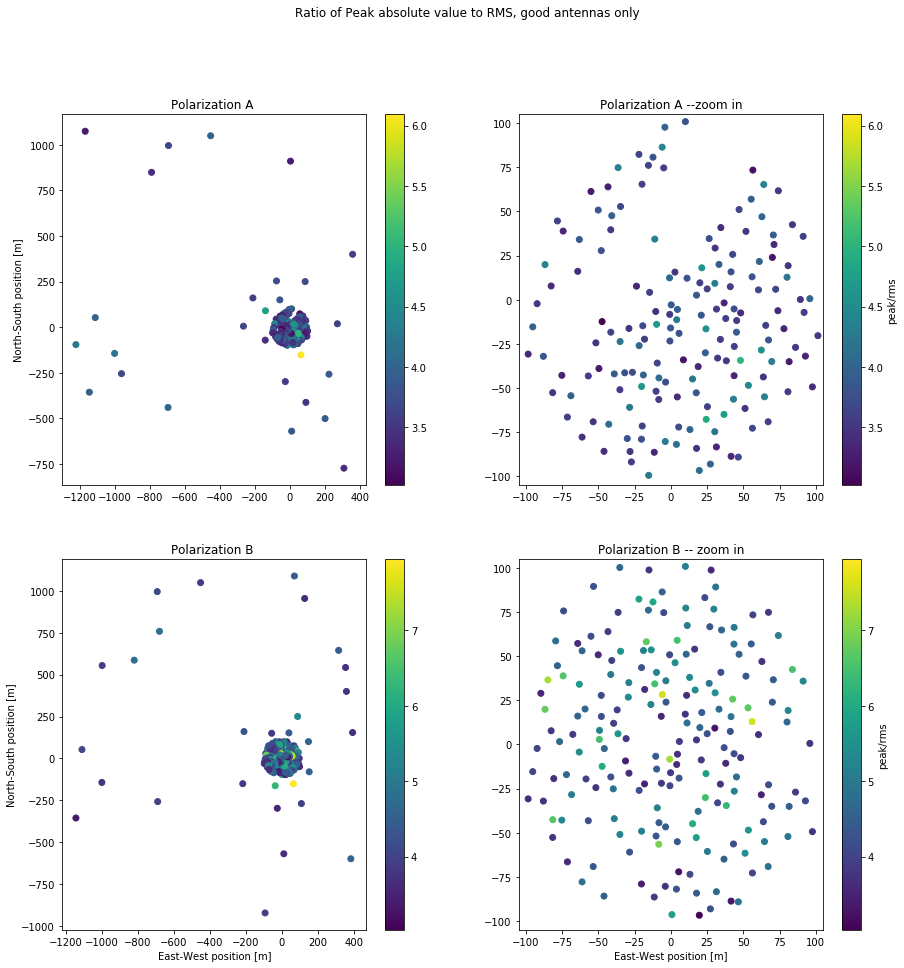

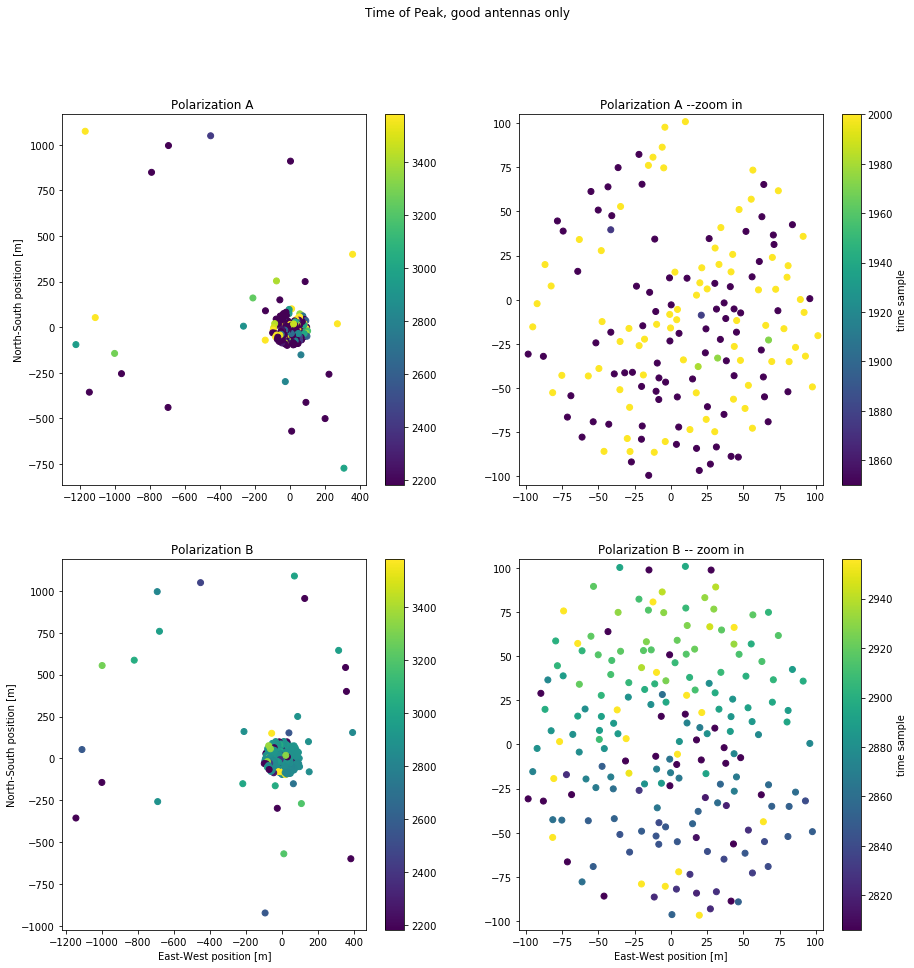

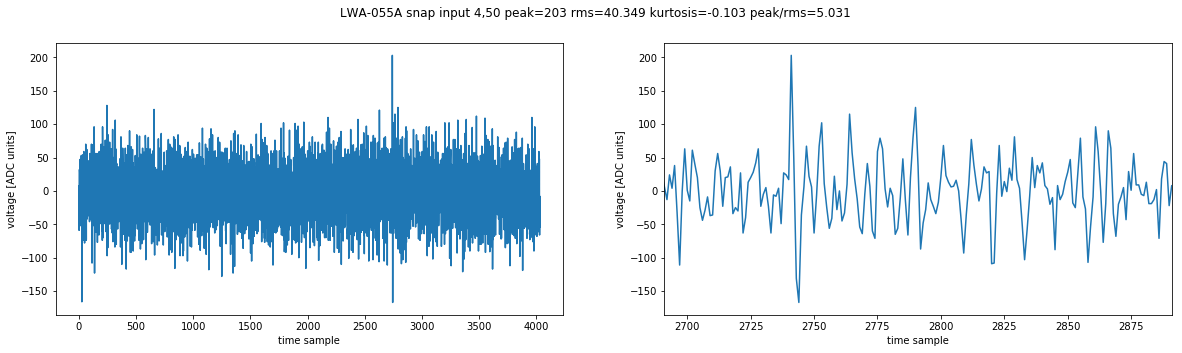

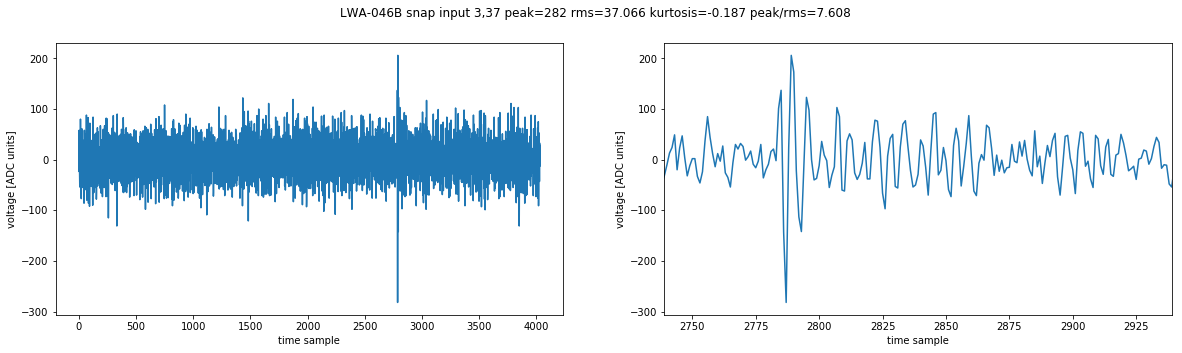

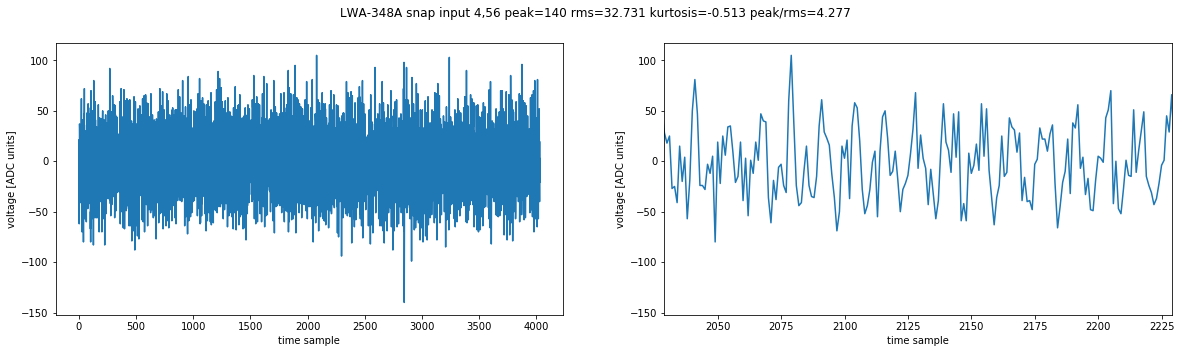

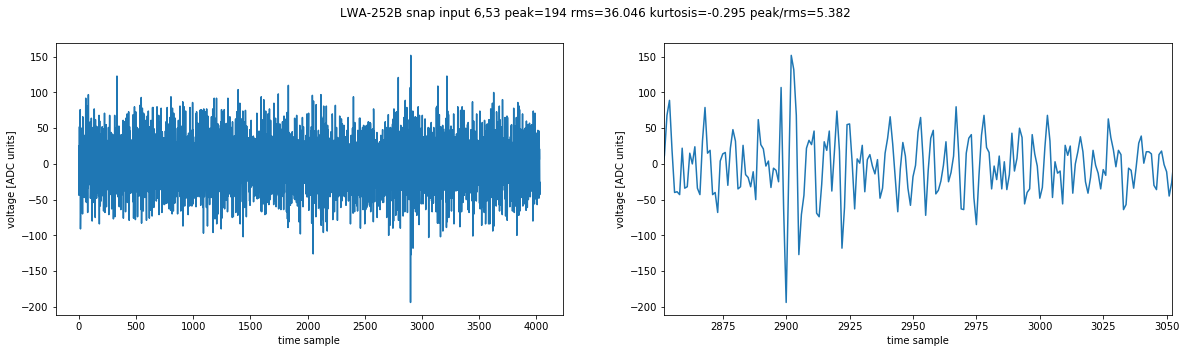

In [120]:

plot_event_peak_to_rms(event_records,arraymapdictionaries,minimum_ok_rms=25,maximum_ok_rms=45,minimum_ok_kurtosis=-1,maximum_ok_kurtosis=1,annotate=False)
plot_event_toas(event_records,arraymapdictionaries,minimum_ok_rms=25,maximum_ok_rms=45,minimum_ok_kurtosis=-1,maximum_ok_kurtosis=1,annotate=False)

coreA,coreB,farA,farB=rank_by_snr(event_records,arraymapdictionaries)
for rankedlist in coreA,coreB,farA,farB:
    if len(rankedlist)>1:
        plot_timeseries(event,[A[1] for A in rankedlist[:1]],zoom='peak')
    else:
        plot_timeseries(event,[A[1] for A in rankedlist],zoom='peak')

I need to do some debugging on reloading events from saved indices, so below I chose one file to start with that I know from the summary has an event that passed all the cuts, and I load the whole file and re-identify the event.

In [67]:
## load data
fname='/data0/cosmic-ray-data/2023May3/overnight1683181342.864461.dat'  #THIS WILL BE COMMAND LINE ARGUMENT
records = parsefile(fname) 


In [68]:


#### set parameters -- eventually this could be read from a config file ######################################
#where to save data products
datadir='/data0/cosmic-ray-data/2023May3/'  #directory where fname is
outdir='/data0/cosmic-ray-data/2023May3-dataproducts/'

#name of csv file with antenna names and coordinates: Columns must have headings 'antname', 'x', 'y', 'elevation'
array_map_filename='/home/ubuntu/kp/lwa-cosmic-rays/array-map-5-22-2023.csv'

#veto setup at the time the data was collected
veto_names=['LWA-316', 'LWA-334', 'LWA-328', 'LWA-326', 'LWA-322', 'LWA-333']
veto_threshold=200 #200 is what was set at the time the data was recorded

#parameters for antenna-based cuts
maximum_ok_rms=45
minimum_ok_rms=25
minsnr=4.472 #calculated to be the raw voltage equivalent of the smoothed power snr threshold that Ryan used 
minimum_ok_kurtosis=-1
maximum_ok_kurtosis=1

#parameters for event-based cuts
minmaxstrengthratio=1.5 #core vs distant ratio
mintop5ratio=1.5 #core vs distant ratio
minstrongdetections1=20 #number of strong detections for an individual polarization
minstrongdetections2=50 #replicate Ryan's cut for strong detections
min_rms_ratio=0.8 #cut for ratio of rms before and after event
max_rms_ratio=1.2 #cut for ratio of rms before and after event

####################################### load data ###########################################################
#records = parsefile(fname)


###################### Organize list of single-antenna records into list of events ############################################
events=distinguishevents(records,200)[100:]  ##TRUNCATING THE LIST ONLY FOR THIS TEST
complete_events=[event for event in events if len(event)==704]


total=len(events)
records_per_event=np.asarray([len(e) for e in events])
complete_events_count=np.sum(records_per_event==704)
incomplete_events_count=np.sum(records_per_event!=704)

scrambled_complete_events=0
for e in complete_events:
    if (e!=[n for n in range(np.min(e),np.min(e)+704)]):
        scrambled_events+=1

########################## load array map ################################
array_map=pd.read_csv(array_map_filename)
xdict={}
ydict={}
zdict={}
for i,n in enumerate(array_map['antname']):
    xdict[n]=array_map['x'][i]
    ydict[n]=array_map['y'][i]
    zdict[n]=array_map['elevation'][i]
arraymapdictionaries=[xdict,ydict,zdict]

##########Calculate Summary info ####################

#arrays to store summary info for each event
rms_ratioA=np.zeros(len(complete_events))
rms_ratioB=np.zeros(len(complete_events))

n_strong_detectionsA=np.zeros(len(complete_events))
n_strong_detectionsB=np.zeros(len(complete_events))

n_veto_detections=np.zeros(len(complete_events))

max_core_vs_far_ratioB=np.zeros(len(complete_events))
max_core_vs_far_ratioA=np.zeros(len(complete_events))
sum_top_5_core_vs_far_ratioA=np.zeros(len(complete_events))
sum_top_5_core_vs_far_ratioB=np.zeros(len(complete_events))

#go through each event
for i,event_indices in enumerate(complete_events):  
    event=[records[i] for i in event_indices]
    mergedrecords=mergepolarizations(event,arraymapdictionaries)

    xcoords=np.asarray([record['x'] for record in mergedrecords])
    ycoords=np.asarray([record['y'] for record in mergedrecords])
    zcoords=np.asarray([record['z'] for record in mergedrecords])
    
    #get rms and peak to rms ratio
    rmsA=np.asarray([record['rmsA'] for record in mergedrecords])
    peakA=np.asarray([record['peakA'] for record in mergedrecords])
    rmsB=np.asarray([record['rmsB'] for record in mergedrecords])
    peakB=np.asarray([record['peakB'] for record in mergedrecords])

    peak_to_rmsA=peakA/rmsA
    peak_to_rmsB=peakB/rmsB
    
    #get kurtosis before event
    kurtosisA=np.asarray([st.kurtosis(record['polA_data'][:2000]) for record in mergedrecords])
    kurtosisB=np.asarray([st.kurtosis(record['polB_data'][:2000]) for record in mergedrecords])

    #calculate rms after event (from 10 samples after the peak to 60 samples after the peak)
    rms_afterA=np.asarray([np.std(record['polA_data'][record['index_peak_A']+10:record['index_peak_A']+60]) for record in mergedrecords]) #could speed it up by only doing rms after event for good antennas
    rms_afterB=np.asarray([np.std(record['polB_data'][record['index_peak_B']+10:record['index_peak_B']+60]) for record in mergedrecords])
        
    #define antenna cut based on rms 
    cut_rmsA = np.logical_and(rmsA >minimum_ok_rms, rmsA <maximum_ok_rms)
    cut_rmsB = np.logical_and(rmsB >minimum_ok_rms, rmsB <maximum_ok_rms)
    
    #define antenna cut based on kurtosis
    cut_kurtosisA = np.logical_and(kurtosisA >minimum_ok_kurtosis, kurtosisA <maximum_ok_kurtosis)
    cut_kurtosisB = np.logical_and(kurtosisB >minimum_ok_kurtosis, kurtosisB <maximum_ok_kurtosis)

    #define antenna cut based on peak to rms ratio
    cut_snrA=(peakA/rmsA) >minsnr
    cut_snrB=(peakB/rmsB) >minsnr

    #combine antenna cuts
    cut_rms_kurtosis_A=np.logical_and(cut_rmsA,cut_kurtosisA)
    cut_rms_kurtosis_B=np.logical_and(cut_rmsB,cut_kurtosisB)

    total_cutA=np.logical_and(cut_rms_kurtosis_A,cut_snrA)
    total_cutB=np.logical_and(cut_rms_kurtosis_B,cut_snrB)
    
    #calculate the number of strong detections and the median ratio of rms before and after
    n_strong_detectionsA[i]=np.sum(total_cutA)
    n_strong_detectionsB[i]=np.sum(total_cutB)

    if len(rmsA[total_cutA]):
        rms_ratioA[i]=np.median(rms_afterA[total_cutA]/(rmsA[total_cutA]))
    else:
        rms_ratioA[i]=-1
    
    if len(rmsB[total_cutB]):
        rms_ratioB[i]=np.median(rms_afterB[total_cutB]/(rmsB[total_cutB]))
    else:
        rms_ratioB[i]=-1

    ## calculate number of veto detections among all the veto antennas that were used at the time
    select_veto_antennas=np.asarray([record['antname'] in veto_names for record in mergedrecords])
    veto_detectionsA=np.logical_and(peakA>veto_threshold,select_veto_antennas)
    veto_detectionsB=np.logical_and(peakB>veto_threshold,select_veto_antennas)
    n_veto_detections[i]=np.sum(veto_detectionsA)+np.sum(veto_detectionsB) #count how many of both polarizations detected it
    
    ## calculate ratio of peak/rms in core vs outriggers
    select_core=(xcoords**2)+(ycoords**2)<(150**2)
    select_far_antennas=(xcoords**2)+(ycoords**2)>(250**2)
    
    core_peak_rms_ratioA=peak_to_rmsA[np.logical_and(select_core,cut_rms_kurtosis_A)]
    far_antennas_peak_rms_ratioA=peak_to_rmsA[np.logical_and(select_far_antennas,cut_rms_kurtosis_A)]
    core_peak_rms_ratioB=peak_to_rmsB[np.logical_and(select_core,cut_rms_kurtosis_B)]
    far_antennas_peak_rms_ratioB=peak_to_rmsB[np.logical_and(select_far_antennas,cut_rms_kurtosis_B)]
    
    if len(core_peak_rms_ratioA) and len(far_antennas_peak_rms_ratioA):
        max_core_vs_far_ratioA[i]=(np.max(core_peak_rms_ratioA))/(np.max(far_antennas_peak_rms_ratioA))
        sort_core_snrA=core_peak_rms_ratioA.copy()
        sort_core_snrA.sort()
        sort_far_snrA=far_antennas_peak_rms_ratioA.copy()
        sort_far_snrA.sort()
        sum_top_5_core_vs_far_ratioA[i]=(np.sum(sort_core_snrA[-5:]))/(np.sum(sort_far_snrA[-5:]))

    else:
        max_core_vs_far_ratioA[i]=-1
        sum_top_5_core_vs_far_ratioA[i]=-1
    
    if len(core_peak_rms_ratioB) and len(far_antennas_peak_rms_ratioB):
        max_core_vs_far_ratioB[i]=(np.max(core_peak_rms_ratioB))/(np.max(far_antennas_peak_rms_ratioB))
        sort_core_snrB=core_peak_rms_ratioB.copy()
        sort_core_snrB.sort()
        sort_far_snrB=far_antennas_peak_rms_ratioB.copy()
        sort_far_snrB.sort()
        sum_top_5_core_vs_far_ratioB[i]=(np.sum(sort_core_snrB[-5:]))/(np.sum(sort_far_snrB[-5:]))

    else:
        max_core_vs_far_ratioB[i]=-1
        sum_top_5_core_vs_far_ratioB[i]=-1
        
####################################################################
########Calculate Selection Cuts#####################################

#number of strong detections
total_strong_detections=n_strong_detectionsA+n_strong_detectionsB
detections_cut2=total_strong_detections>minstrongdetections2

#cut on events based on rms change and number of strong detections
rms_change_cutA=np.logical_and(rms_ratioA>min_rms_ratio,rms_ratioA<max_rms_ratio)
rms_change_cutB=np.logical_and(rms_ratioB>min_rms_ratio,rms_ratioB<max_rms_ratio)

#Iff a polarization has strong detections, it must satisfy the rms change cut
rms_change_cut_for_strong_detectionsA=np.logical_or(rms_change_cutA,n_strong_detectionsA<minstrongdetections1)
rms_change_cut_for_strong_detectionsB=np.logical_or(rms_change_cutB,n_strong_detectionsB<minstrongdetections1)

#At least one polarization must satisfy above
rms_change_cut=np.logical_and(rms_change_cut_for_strong_detectionsA,rms_change_cut_for_strong_detectionsB)

#cut on total number of veto antenna detections
maxveto=1  #throw away things detected by 2 or more veto antennas
veto_cut=n_veto_detections<=maxveto

#cut for events that are weaker for the distant antennas
max_distant_vs_core_cut=np.logical_or(max_core_vs_far_ratioA>minmaxstrengthratio,max_core_vs_far_ratioB>minmaxstrengthratio)
top5_distant_vs_core_cut=np.logical_or(sum_top_5_core_vs_far_ratioA>mintop5ratio,sum_top_5_core_vs_far_ratioB>mintop5ratio)

distant_vs_core_cut2=np.logical_or(top5_distant_vs_core_cut,max_distant_vs_core_cut) #I'm combining two metrics since they select very non overlapping subsets so far

############################Apply Selection Cuts##########################################

total_events_cut1=np.logical_and(np.logical_and(rms_change_cut,detections_cut2),top5_distant_vs_core_cut)
select_events1=[complete_events[i] for i in range(len(complete_events)) if total_events_cut1[i]]
n_selected1=len(select_events1)

total_events_cut2=np.logical_and(np.logical_and(np.logical_and(rms_change_cut,detections_cut2),distant_vs_core_cut2),veto_cut)
select_events2=[complete_events[i] for i in range(len(complete_events)) if total_events_cut2[i]]
n_selected2=len(select_events2)


/home/ubuntu/anaconda3/envs/deployment/lib/python3.6/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/ubuntu/anaconda3/envs/deployment/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/ubuntu/anaconda3/envs/deployment/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ubuntu/anaconda3/envs/deployment/lib/python3.6/site-packages/ipykernel_launcher.py:182: RuntimeWarning: invalid value encountered in greater
/home/ubuntu/anaconda3/envs/deployment/lib/python3.6/site-packages/ipykernel_launcher.py:182: RuntimeWarning: invalid value encountered in less
/home/ubuntu/anaconda3/envs/deployment/lib/python3.6/site-packages/ipykernel_launcher.py:183: RuntimeWarning: invalid value encountered 

In [73]:
print(len(select_events1))

## load array map
array_map=pd.read_csv('array-map-5-22-2023.csv')
xdict={}
ydict={}
zdict={}
for i,n in enumerate(array_map['antname']):
    xdict[n]=array_map['x'][i]
    ydict[n]=array_map['y'][i]
    zdict[n]=array_map['elevation'][i]
arraymapdictionaries=[xdict,ydict,zdict]

1


peak ratio A 1.1762385061784777
peak ratio B 1.4135957022898622
top 5 ratio A 1.1736495164072298
top 5 ratio B 1.5261968132364527


/home/ubuntu/anaconda3/envs/deployment/lib/python3.6/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


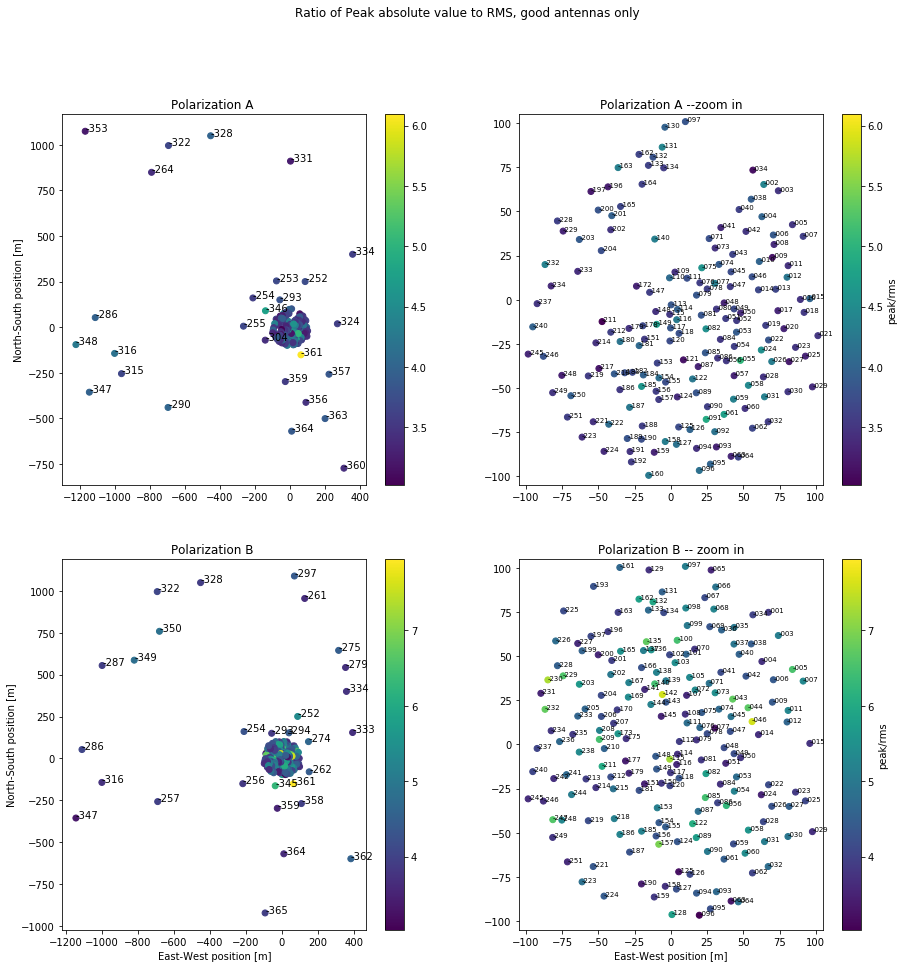

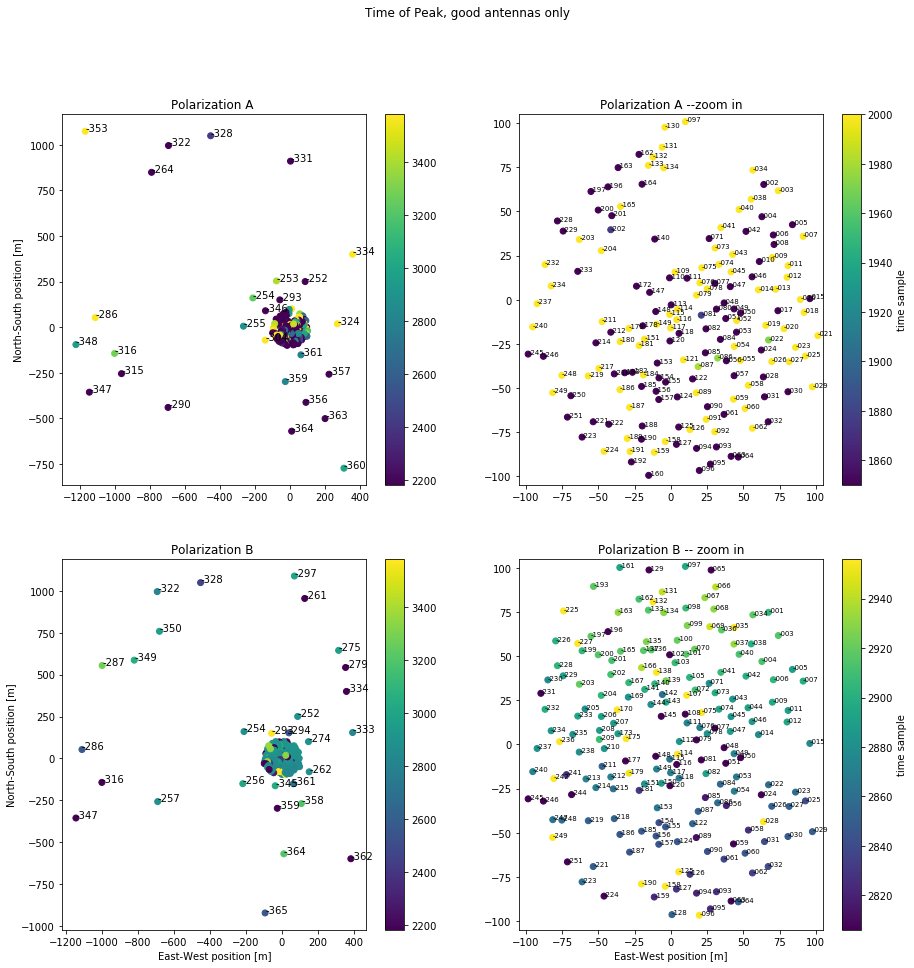

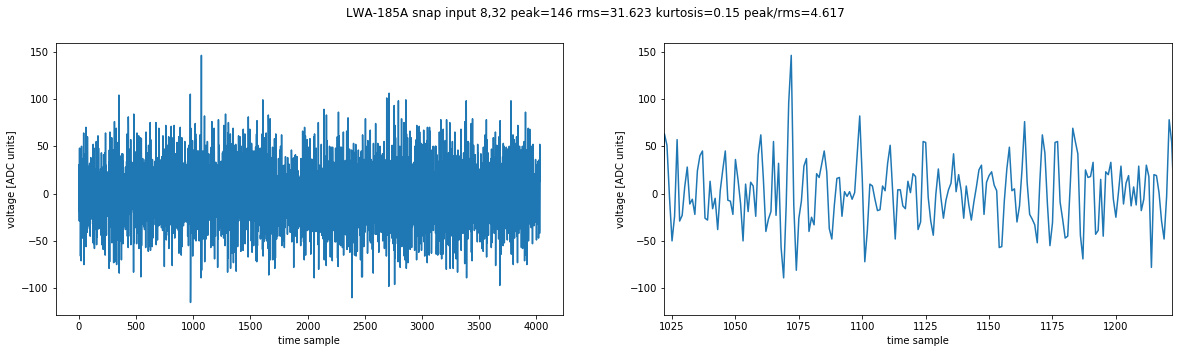

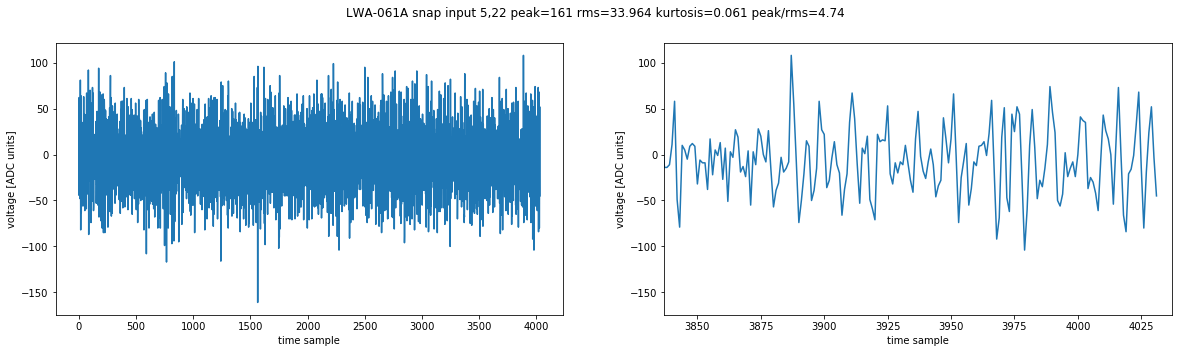

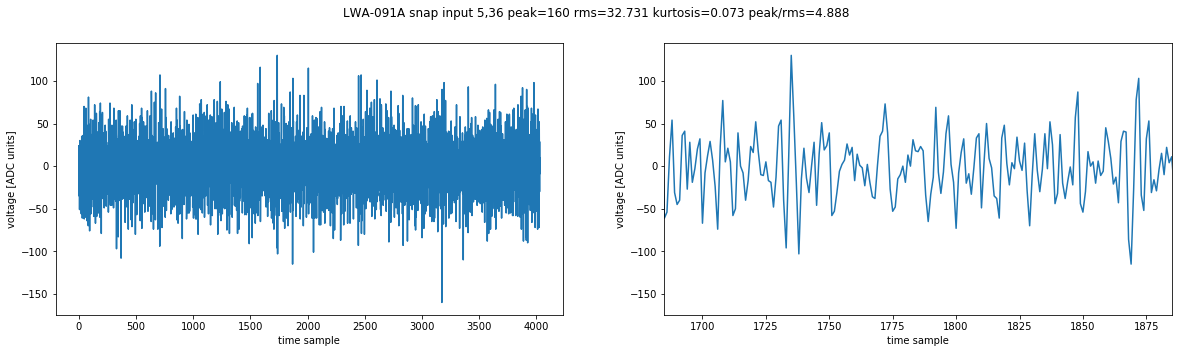

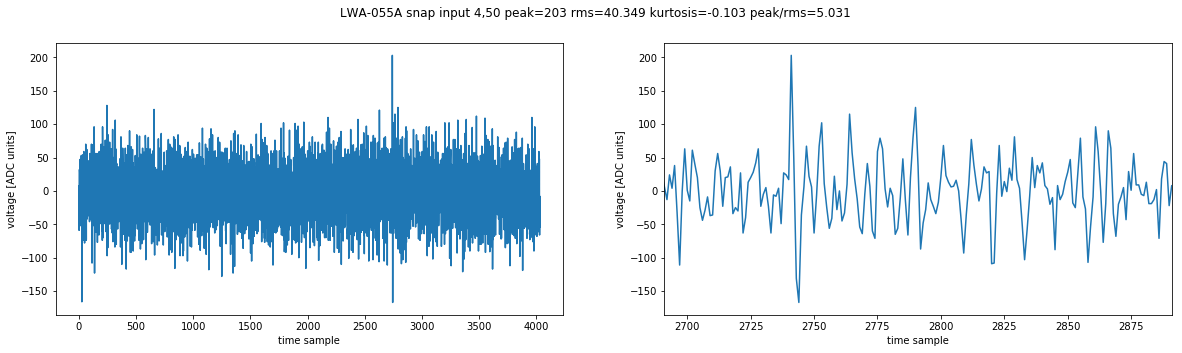

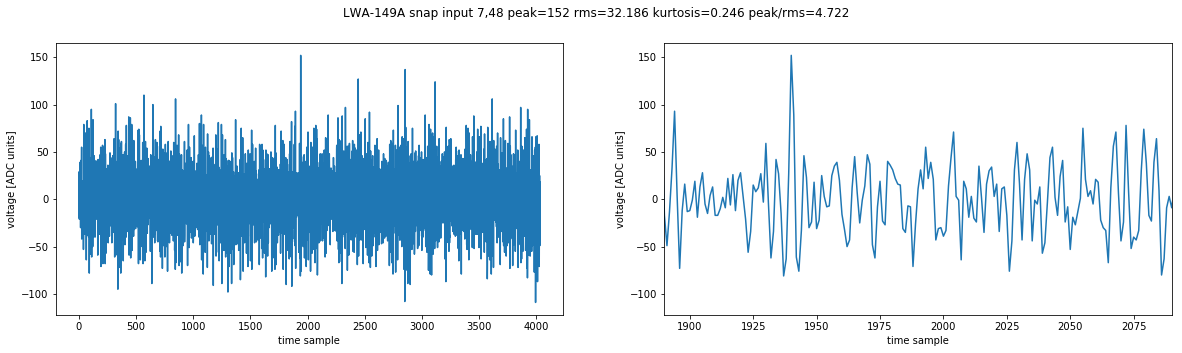

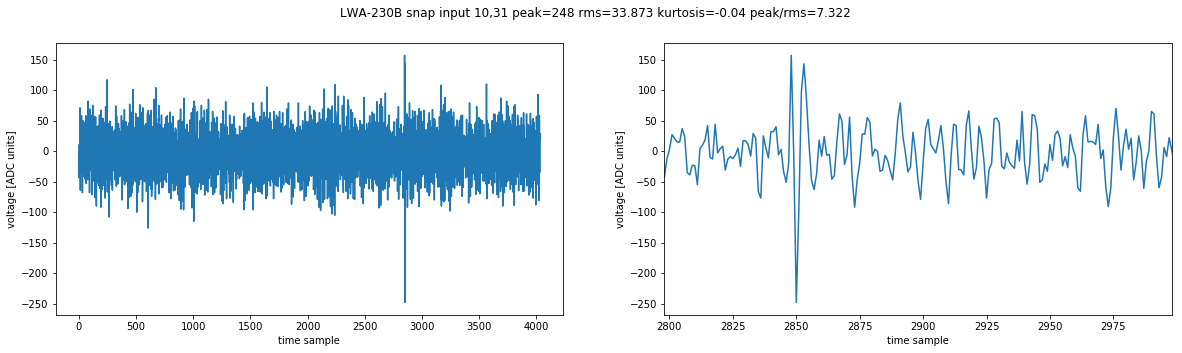

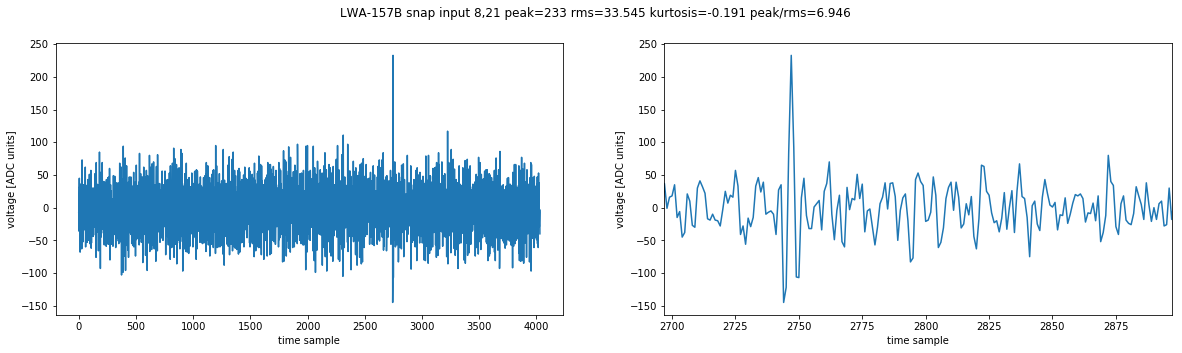

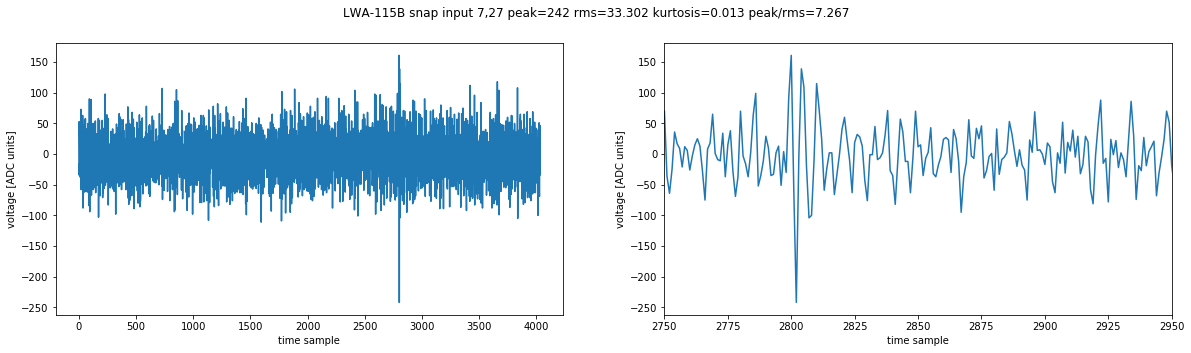

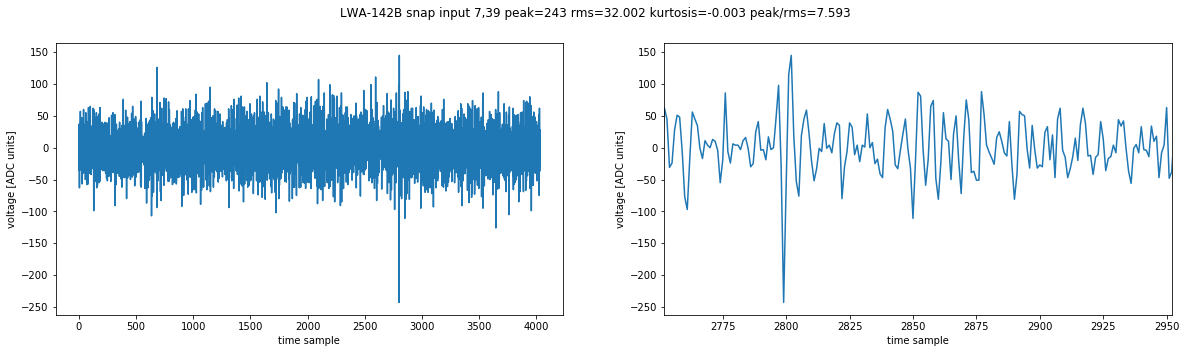

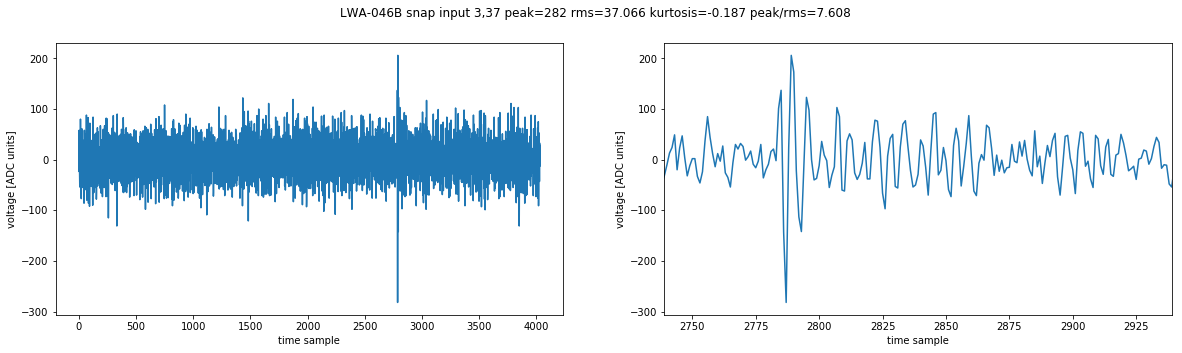

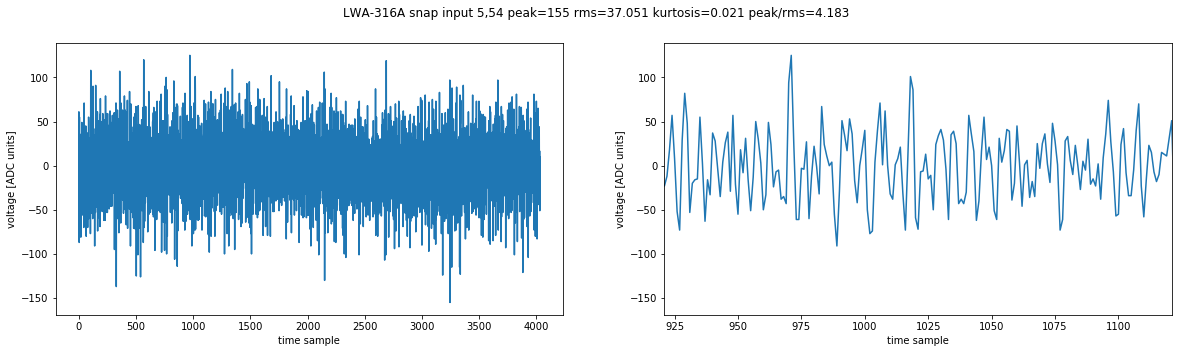

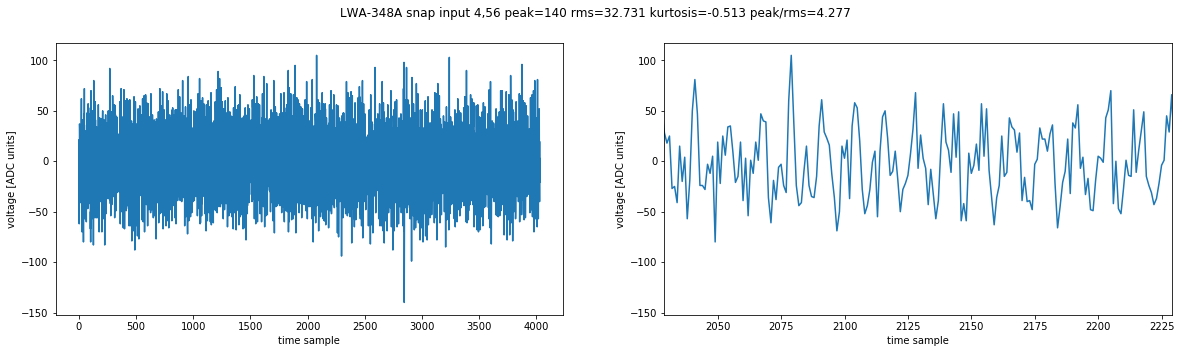

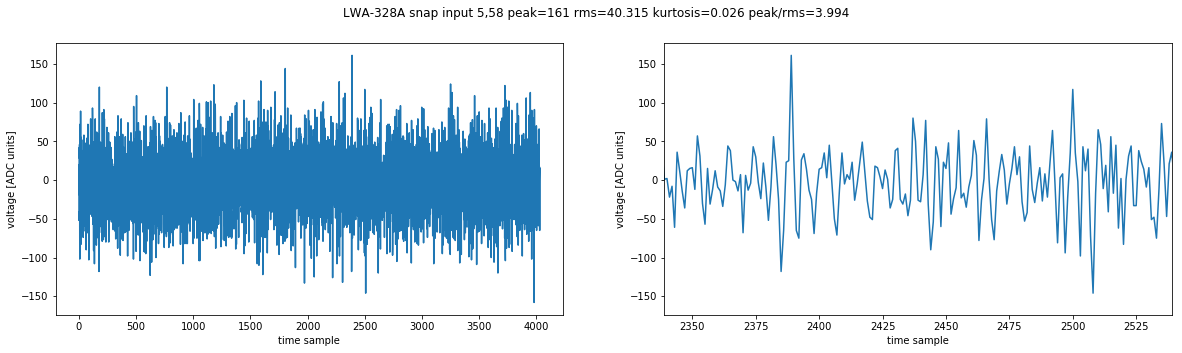

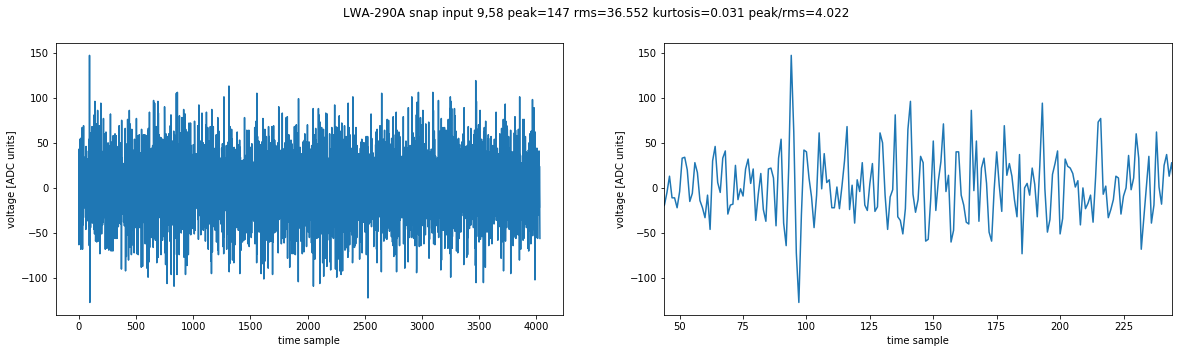

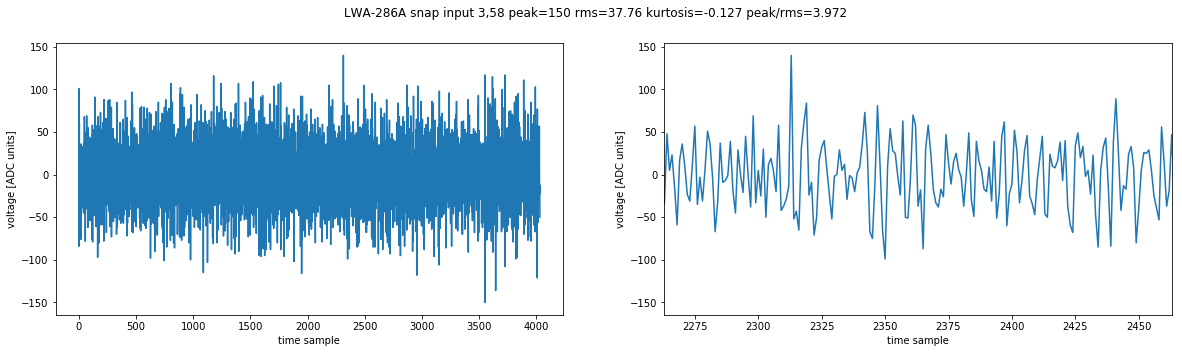

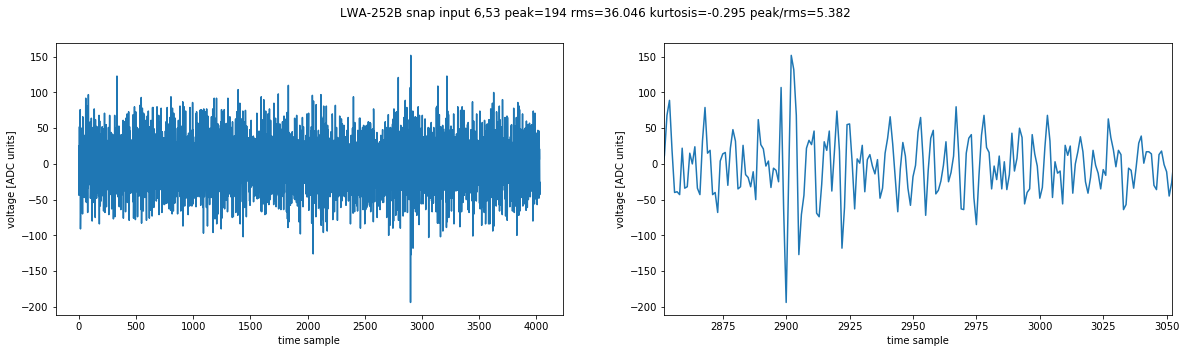

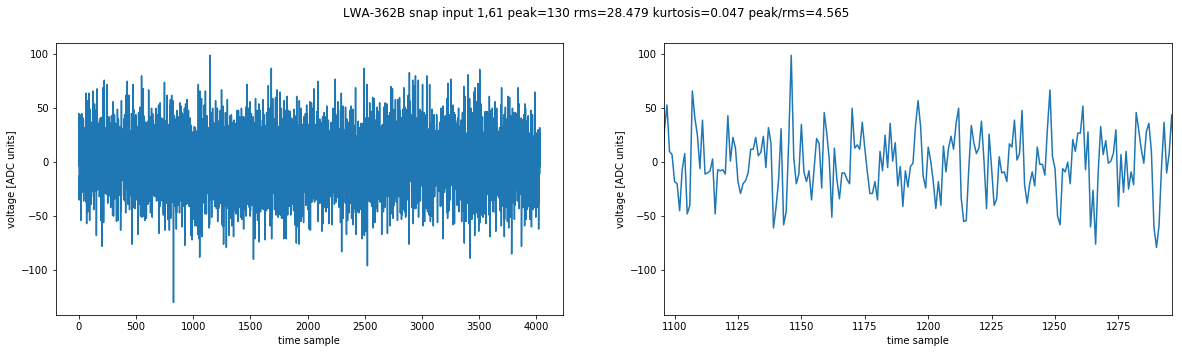

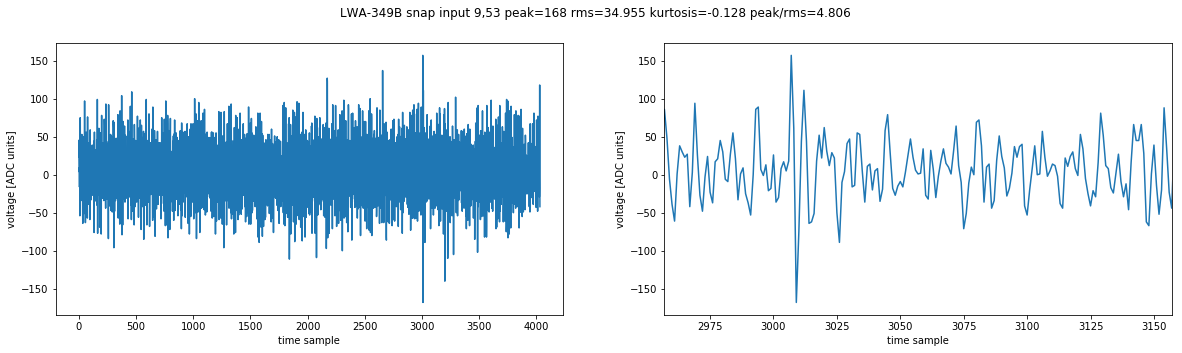

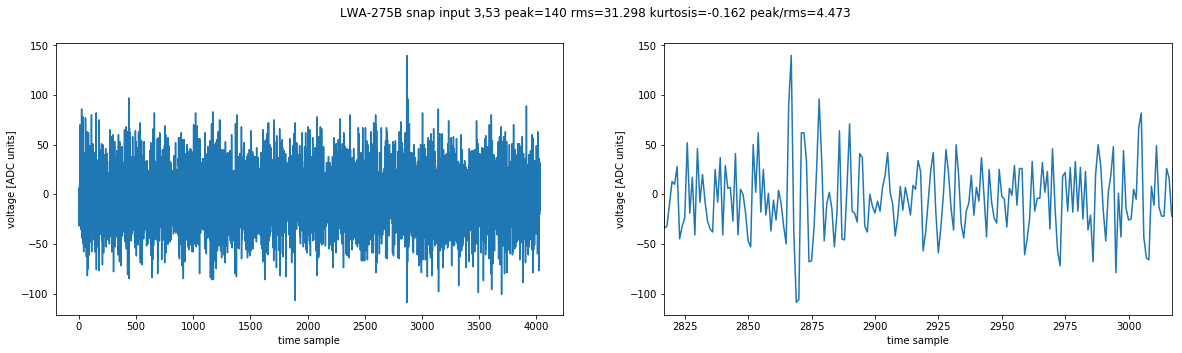

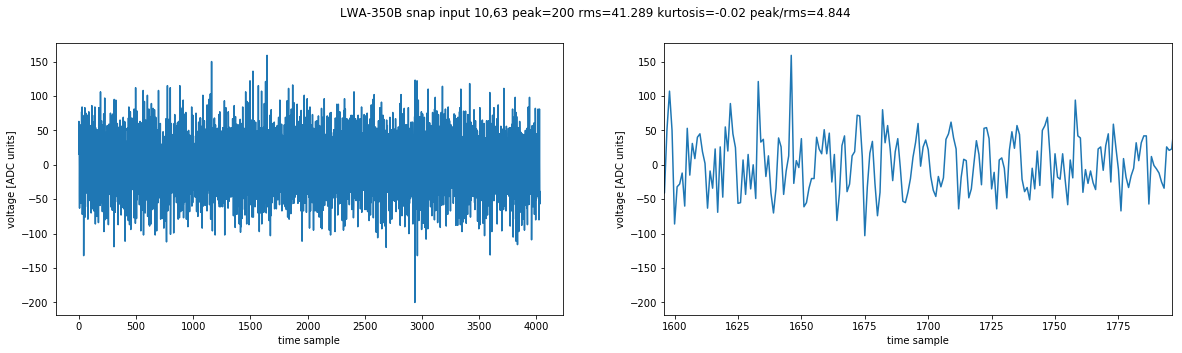

In [88]:
event_indices = select_events1[0]
event=[records[i] for i in event_indices]
plot_event_peak_to_rms(event,arraymapdictionaries,minimum_ok_rms=25,maximum_ok_rms=45,minimum_ok_kurtosis=-1,maximum_ok_kurtosis=1,annotate=True)
plot_event_toas(event,arraymapdictionaries,minimum_ok_rms=25,maximum_ok_rms=45,minimum_ok_kurtosis=-1,maximum_ok_kurtosis=1,annotate=True)

coreA,coreB,farA,farB=rank_by_snr(event,arraymapdictionaries)
print('peak ratio A', coreA[0][0]/farA[0][0])
print('peak ratio B', coreB[0][0]/farB[0][0])

print('top 5 ratio A',sum([e[0] for e in coreA[:5]])/sum([e[0] for e in farA[:5]]))
print('top 5 ratio B',sum([e[0] for e in coreB[:5]])/sum([e[0] for e in farB[:5]]))


for rankedlist in coreA,coreB,farA,farB:
    if len(rankedlist)>5:
        #print(rankedlist[:5])
        plot_timeseries(event,[A[1] for A in rankedlist[:5]],zoom='peak')
    else:
        #print(rankedlist)
        plot_timeseries(event,[A[1] for A in rankedlist],zoom='peak')

In [87]:

def plot_event_peak_to_rms(event,arraymapdictionaries,minimum_ok_rms=25,maximum_ok_rms=45,minimum_ok_kurtosis=-1,maximum_ok_kurtosis=1,annotate=False):
    import scipy.stats as st
    #Plots the peak to rms ratio for each polarization of an event, over the antenna positions of the array
    #Event is a list of records (single-packet dictionaries) belonging to the same event
    #Antennas are filtered to only plot antennas whose signals (in the first half of the buffer) are within the
    #bounds set by minimum_ok_rms, maximum_ok_rms, minimum_ok_kurtosis, maximum_ok_kurtosis
    #Antennas are labelled if annotate=True
    
    mergedrecords=mergepolarizations(event,arraymapdictionaries)

    xcoords=np.asarray([record['x'] for record in mergedrecords])
    ycoords=np.asarray([record['y'] for record in mergedrecords])
    zcoords=np.asarray([record['z'] for record in mergedrecords])
    antnames=[record['antname'] for record in mergedrecords]
    #get rms and peak to rms ratio
    rmsA=np.asarray([record['rmsA'] for record in mergedrecords])
    peakA=np.asarray([record['peakA'] for record in mergedrecords])
    rmsB=np.asarray([record['rmsB'] for record in mergedrecords])
    peakB=np.asarray([record['peakB'] for record in mergedrecords])

    peak_to_rmsA=peakA/rmsA
    peak_to_rmsB=peakB/rmsB
    
    #get kurtosis before event
    kurtosisA=np.asarray([st.kurtosis(record['polA_data'][:2000]) for record in mergedrecords])
    kurtosisB=np.asarray([st.kurtosis(record['polB_data'][:2000]) for record in mergedrecords])

    #define antenna cut based on rms 
    cut_rmsA = np.logical_and(rmsA >minimum_ok_rms, rmsA <maximum_ok_rms)
    cut_rmsB = np.logical_and(rmsB >minimum_ok_rms, rmsB <maximum_ok_rms)
    
    #define antenna cut based on kurtosis
    cut_kurtosisA = np.logical_and(kurtosisA >minimum_ok_kurtosis, kurtosisA <maximum_ok_kurtosis)
    cut_kurtosisB = np.logical_and(kurtosisB >minimum_ok_kurtosis, kurtosisB <maximum_ok_kurtosis)

    #combine antenna cuts
    cutA=np.logical_and(cut_rmsA,cut_kurtosisA)
    cutB=np.logical_and(cut_rmsB,cut_kurtosisB)

    
    select_core_antennas=(xcoords**2)+(ycoords**2)<(115**2)
    select_far_antennas=(xcoords**2)+(ycoords**2)>(115**2)  #note the core vs far cuts used in plotting are different than what's used for estimating if event is concentrated on core
    

    plt.figure(figsize=(15,15))
    plt.suptitle('Ratio of Peak absolute value to RMS, good antennas only')
    plt.subplot(221)
    plt.title("Polarization A ")
    plt.scatter(xcoords[cutA],ycoords[cutA],c=peak_to_rmsA[cutA])
    plt.colorbar()
    plt.ylabel('North-South position [m]')
    if annotate:
        for i in range(len(antnames)):
            if cutA[i] and select_far_antennas[i]:
                txt=antnames[i]
                x=xcoords[i]
                y=ycoords[i]
                plt.annotate(txt[3:], (x, y))
    
    plt.subplot(222)
    plt.title("Polarization A --zoom in")
    plt.scatter(xcoords[cutA],ycoords[cutA],c=peak_to_rmsA[cutA])
    plt.xlim(-105,105)
    plt.ylim(-105,105)
    plt.colorbar(label='peak/rms')
    #plt.clim(cmin,cmax)
    if annotate:
        for i in range(len(antnames)):
            if cutA[i] and select_core_antennas[i]:
                txt=antnames[i]
                x=xcoords[i]
                y=ycoords[i]
                plt.text(x,y,txt[3:],fontsize='x-small')
                
    plt.subplot(223)
    plt.title("Polarization B ")
    plt.scatter(xcoords[cutB],ycoords[cutB],c=peak_to_rmsB[cutB])
    plt.colorbar()
    plt.xlabel('East-West position [m]')
    plt.ylabel('North-South position [m]')
    if annotate:
        for i in range(len(antnames)):
            if cutB[i] and select_far_antennas[i]:
                txt=antnames[i]
                x=xcoords[i]
                y=ycoords[i]
                plt.annotate(txt[3:], (x, y))

    plt.subplot(224)
    plt.title("Polarization B -- zoom in")
    plt.scatter(xcoords[cutB],ycoords[cutB],c=peak_to_rmsB[cutB])
    plt.xlim(-105,105)
    plt.ylim(-105,105)
    plt.colorbar(label='peak/rms')
    plt.xlabel('East-West position [m]')
    
    if annotate:
        for i in range(len(antnames)):
            if cutB[i] and select_core_antennas[i]:
                txt=antnames[i]
                x=xcoords[i]
                y=ycoords[i]
                plt.text(x,y,txt[3:],fontsize='x-small')

    return

def plot_event_toas(event,arraymapdictionaries,minimum_ok_rms=25,maximum_ok_rms=45,minimum_ok_kurtosis=-1,maximum_ok_kurtosis=1,annotate=False,):
    import scipy.stats as st

    #Plots the time of arrival for each antenna and polarization of an event, over the antenna positions of the array
    #time of arrival is in units of clock cycles with respect to the earliest packet timestamp in the event
    #Event is a list of records (single-packet dictionaries) belonging to the same event
    #Antennas are filtered to only plot antennas whose signals (in the first half of the buffer) are within the
    #bounds set by minimum_ok_rms, maximum_ok_rms, minimum_ok_kurtosis, maximum_ok_kurtosis
    #Antennas are labelled if annotate=True
    
    mergedrecords=mergepolarizations(event,arraymapdictionaries)

    xcoords=np.asarray([record['x'] for record in mergedrecords])
    ycoords=np.asarray([record['y'] for record in mergedrecords])
    zcoords=np.asarray([record['z'] for record in mergedrecords])
    antnames=[record['antname'] for record in mergedrecords]
    #get rms 
    rmsA=np.asarray([record['rmsA'] for record in mergedrecords])
    rmsB=np.asarray([record['rmsB'] for record in mergedrecords])

    #get time of peak
    index_peak_A=np.asarray([record['index_peak_A'] for record in mergedrecords])
    index_peak_B=np.asarray([record['index_peak_B'] for record in mergedrecords])
    timestamps=np.asarray([record['timestamp'] for record in mergedrecords])
    min_time=np.min(timestamps)

    t_rel_A=index_peak_A + timestamps - min_time
    t_rel_B=index_peak_B + timestamps - min_time
    
    
    #get kurtosis before event
    kurtosisA=np.asarray([st.kurtosis(record['polA_data'][:2000]) for record in mergedrecords])
    kurtosisB=np.asarray([st.kurtosis(record['polB_data'][:2000]) for record in mergedrecords])

    #define antenna cut based on rms 
    cut_rmsA = np.logical_and(rmsA >minimum_ok_rms, rmsA <maximum_ok_rms)
    cut_rmsB = np.logical_and(rmsB >minimum_ok_rms, rmsB <maximum_ok_rms)
    
    #define antenna cut based on kurtosis
    cut_kurtosisA = np.logical_and(kurtosisA >minimum_ok_kurtosis, kurtosisA <maximum_ok_kurtosis)
    cut_kurtosisB = np.logical_and(kurtosisB >minimum_ok_kurtosis, kurtosisB <maximum_ok_kurtosis)

    #combine antenna cuts
    cutA=np.logical_and(cut_rmsA,cut_kurtosisA)
    cutB=np.logical_and(cut_rmsB,cut_kurtosisB)

    
    select_core_antennas=(xcoords**2)+(ycoords**2)<(115**2)
    select_far_antennas=(xcoords**2)+(ycoords**2)>(115**2)  #note the core vs far cuts used in plotting are different than what's used for estimating if event is concentrated on core
    

    plt.figure(figsize=(15,15))
    plt.suptitle('Time of Peak, good antennas only')
    plt.subplot(221)
    plt.title("Polarization A ")
    plt.scatter(xcoords[cutA],ycoords[cutA],c=t_rel_A[cutA])
    plt.colorbar()
    plt.clim(np.median(t_rel_B[cutB])-700,np.median(t_rel_B[cutB])+700)
    plt.ylabel('North-South position [m]')
    if annotate:
        for i in range(len(antnames)):
            if cutA[i] and select_far_antennas[i]:
                txt=antnames[i]
                x=xcoords[i]
                y=ycoords[i]
                plt.annotate(txt[3:], (x, y))
    
    plt.subplot(222)
    plt.title("Polarization A --zoom in")
    plt.scatter(xcoords[cutA],ycoords[cutA],c=t_rel_A[cutA])
    plt.xlim(-105,105)
    plt.ylim(-105,105)
    plt.colorbar(label='time sample')
    plt.clim(np.median(t_rel_A[cutA])-75,np.median(t_rel_A[cutA])+75)
    if annotate:
        for i in range(len(antnames)):
            if cutA[i] and select_core_antennas[i]:
                txt=antnames[i]
                x=xcoords[i]
                y=ycoords[i]
                plt.text(x,y,txt[3:],fontsize='x-small')
                
    plt.subplot(223)
    plt.title("Polarization B ")
    plt.scatter(xcoords[cutB],ycoords[cutB],c=t_rel_B[cutB])
    plt.colorbar()
    plt.clim(np.median(t_rel_B[cutB])-700,np.median(t_rel_B[cutB])+700)

    plt.xlabel('East-West position [m]')
    plt.ylabel('North-South position [m]')
    if annotate:
        for i in range(len(antnames)):
            if cutB[i] and select_far_antennas[i]:
                txt=antnames[i]
                x=xcoords[i]
                y=ycoords[i]
                plt.annotate(txt[3:], (x, y))

    plt.subplot(224)
    plt.title("Polarization B -- zoom in")
    plt.scatter(xcoords[cutB],ycoords[cutB],c=t_rel_B[cutB])
    plt.xlim(-105,105)
    plt.ylim(-105,105)
    plt.colorbar(label='time sample')
    plt.clim(np.median(t_rel_B[cutB])-75,np.median(t_rel_B[cutB])+75)
    plt.xlabel('East-West position [m]')
    
    if annotate:
        for i in range(len(antnames)):
            if cutB[i] and select_core_antennas[i]:
                txt=antnames[i]
                x=xcoords[i]
                y=ycoords[i]
                plt.text(x,y,txt[3:],fontsize='x-small')

    return


def plot_timeseries(event,antenna_names,zoom='peak'):
    import scipy.stats as st
    #Event is a list of records (single-packet dictionaries) belonging to the same event
    #antennas is a list where each element in the list is a tuple of format (s,a) where s is the index of the snap board and a is the index of the antenna to plot
    #If a requested antenna to plot is not in the list (which happens if that packet has been lost), the missing antenna is skipped
    #The requested antennas are plotted in the order they appear in event, not in the order of the input list
    #zoom is either the string 'peak' or a tuple specifying the range of samples to restrict the x axis to
    for record in event:
        s=record['board_id']
        a=record['antenna_id']
        antname=mapping.snap2_to_antpol(s,a)
        if antname in antenna_names:
            timeseries=record['data']
            rms=np.std(timeseries[:2000])
            kurtosis=st.kurtosis(timeseries[:2000])
            peak=np.max(np.abs(timeseries))
            plt.figure(figsize=(20,5))
            plt.suptitle(antname + ' snap input '+ str(s) +','+ str(a) + ' peak='+str(peak)+' rms='+str(round(rms,3))+' kurtosis='+str(round(kurtosis,3))+' peak/rms='+str(round(peak/rms,3)))
            
            plt.subplot(121)
            plt.plot(timeseries)
            plt.xlabel('time sample')
            plt.ylabel('voltage [ADC units]')

            plt.subplot(122)
            plt.plot(timeseries)
            plt.xlabel('time sample')
            plt.ylabel('voltage [ADC units]')
            if zoom=='peak':
                plt.xlim(np.argmax(timeseries)-50,np.argmax(timeseries)+150)
            else:
                plt.xlim(zoom[0],zoom[1])
            
    return


In [85]:
def rank_by_snr(event,arraymapdictionaries,minimum_ok_rms=25,maximum_ok_rms=45,minimum_ok_kurtosis=-1,maximum_ok_kurtosis=1):
    import scipy.stats as st
    # Return a list of antenna names and snrs in order from strongest snr to smallest , in separate rankings for each polarization and for core and distant antennas
    #Event is a list of records (single-packet dictionaries) belonging to the same event
    #Only antennas with signals (in the first half of the buffer) that satisfy the specified rms and kurtosis cuts are included in the ranking
    
    mergedrecords=mergepolarizations(event,arraymapdictionaries)

    xcoords=np.asarray([record['x'] for record in mergedrecords])
    ycoords=np.asarray([record['y'] for record in mergedrecords])
    zcoords=np.asarray([record['z'] for record in mergedrecords])
    antnames=[record['antname'] for record in mergedrecords]
    #get rms and peak to rms ratio
    rmsA=np.asarray([record['rmsA'] for record in mergedrecords])
    peakA=np.asarray([record['peakA'] for record in mergedrecords])
    rmsB=np.asarray([record['rmsB'] for record in mergedrecords])
    peakB=np.asarray([record['peakB'] for record in mergedrecords])

    peak_to_rmsA=peakA/rmsA
    peak_to_rmsB=peakB/rmsB
    
    #get kurtosis before event
    kurtosisA=np.asarray([st.kurtosis(record['polA_data'][:2000]) for record in mergedrecords])
    kurtosisB=np.asarray([st.kurtosis(record['polB_data'][:2000]) for record in mergedrecords])

    #define antenna cut based on rms 
    cut_rmsA = np.logical_and(rmsA >minimum_ok_rms, rmsA <maximum_ok_rms)
    cut_rmsB = np.logical_and(rmsB >minimum_ok_rms, rmsB <maximum_ok_rms)
    
    #define antenna cut based on kurtosis
    cut_kurtosisA = np.logical_and(kurtosisA >minimum_ok_kurtosis, kurtosisA <maximum_ok_kurtosis)
    cut_kurtosisB = np.logical_and(kurtosisB >minimum_ok_kurtosis, kurtosisB <maximum_ok_kurtosis)

    #combine antenna cuts
    cutA=np.logical_and(cut_rmsA,cut_kurtosisA)
    cutB=np.logical_and(cut_rmsB,cut_kurtosisB)

    
    select_core_antennas=(xcoords**2)+(ycoords**2)<(150**2)
    select_far_antennas=(xcoords**2)+(ycoords**2)>(250**2)  #note the core vs far cuts used in plotting are different than what's used for estimating if event is concentrated on core
    
    #apply antenna quality cuts
    peak_to_rmsA_good_core=peak_to_rmsA[np.logical_and(cutA,select_core_antennas)]    
    ants_good_core_A=[antnames[i]+'A' for i in range(len(antnames)) if (cutA[i] and select_core_antennas[i]) ]
    peak_to_rmsB_good_core=peak_to_rmsB[np.logical_and(cutB,select_core_antennas)]
    ants_good_core_B=[antnames[i]+'B' for i in range(len(antnames)) if (cutB[i] and select_core_antennas[i]) ]
    peak_to_rmsA_good_far=peak_to_rmsA[np.logical_and(cutA,select_far_antennas)]
    ants_good_far_A=[antnames[i]+'A' for i in range(len(antnames)) if (cutA[i] and select_far_antennas[i])]
    peak_to_rmsB_good_far=peak_to_rmsB[np.logical_and(cutB,select_far_antennas)]
    ants_good_far_B=[antnames[i]+'B' for i in range(len(antnames)) if (cutB[i] and select_far_antennas[i])]

    # sort by snr and take the top 5 in each category
    
    ranked_core_A_pol=[pair for pair in sorted(zip(peak_to_rmsA_good_core,ants_good_core_A),reverse=True)]
    ranked_core_B_pol=[pair for pair in sorted(zip(peak_to_rmsB_good_core,ants_good_core_B),reverse=True)]
    ranked_far_A_pol=[pair for pair in sorted(zip(peak_to_rmsA_good_far,ants_good_far_A),reverse=True)]
    ranked_far_B_pol=[pair for pair in sorted(zip(peak_to_rmsB_good_far,ants_good_far_B),reverse=True)]
    
    return ranked_core_A_pol,ranked_core_B_pol,ranked_far_A_pol,ranked_far_B_pol
